In [1]:
import tensorflow as tf
import numpy as np
import os, glob
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from keras.models import Model, load_model
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# 데이터 업로드


In [2]:
from google.colab import files

uploaded = files.upload()

Saving 2d_images.zip to 2d_images.zip
Saving 2d_masks.zip to 2d_masks.zip


In [3]:
!unzip /content/2d_images.zip -d 2d_images
!unzip /content/2d_masks.zip -d 2d_masks

Archive:  /content/2d_images.zip
  inflating: 2d_images/2d_images.zip  
Archive:  /content/2d_masks.zip
  inflating: 2d_masks/2d_masks.zip   


In [4]:
!unzip /content/2d_images/2d_images.zip -d 2d_images
!unzip /content/2d_masks/2d_masks.zip -d 2d_masks

Archive:  /content/2d_images/2d_images.zip
 extracting: 2d_images/ID_0000_Z_0142.tif  
 extracting: 2d_images/ID_0001_Z_0146.tif  
 extracting: 2d_images/ID_0002_Z_0162.tif  
 extracting: 2d_images/ID_0003_Z_0132.tif  
 extracting: 2d_images/ID_0004_Z_0066.tif  
 extracting: 2d_images/ID_0005_Z_0066.tif  
 extracting: 2d_images/ID_0006_Z_0206.tif  
 extracting: 2d_images/ID_0007_Z_0211.tif  
 extracting: 2d_images/ID_0008_Z_0065.tif  
 extracting: 2d_images/ID_0009_Z_0114.tif  
 extracting: 2d_images/ID_0010_Z_0259.tif  
 extracting: 2d_images/ID_0011_Z_0156.tif  
 extracting: 2d_images/ID_0012_Z_0167.tif  
 extracting: 2d_images/ID_0013_Z_0047.tif  
 extracting: 2d_images/ID_0014_Z_0116.tif  
 extracting: 2d_images/ID_0015_Z_0136.tif  
 extracting: 2d_images/ID_0016_Z_0208.tif  
 extracting: 2d_images/ID_0017_Z_0061.tif  
 extracting: 2d_images/ID_0018_Z_0069.tif  
 extracting: 2d_images/ID_0019_Z_0088.tif  
 extracting: 2d_images/ID_0020_Z_0070.tif  
 extracting: 2d_images/ID_0021_Z_

In [5]:
# .tif 형식의 이미지를 불러옴
img_list = sorted(glob.glob('/content/2d_images/*.tif'))
mask_list = sorted(glob.glob('/content/2d_masks/*.tif'))

print(len(img_list), len(mask_list))

267 267


# 데이터 전처리

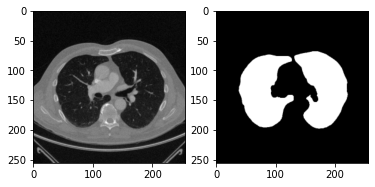

In [6]:
# 데이터 전처리 (resize, 정규화)

x_data, y_data = np.empty((2, 267, 256, 256, 1), dtype=np.float32)

for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(256, 256, 1), preserve_range=True)
    x_data[i] = img
    
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(256, 256, 1), preserve_range=True)
    y_data[i] = img

x_data /= 255.    
y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[0].squeeze(), cmap='gray')
ax[1].imshow(y_data[0].squeeze(), cmap='gray')

In [7]:
x_data.shape, y_data.shape

((267, 256, 256, 1), (267, 256, 256, 1))

In [8]:
# 데이터셋을 나눠주기
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


# FCN (Fully Convolutional Networks)

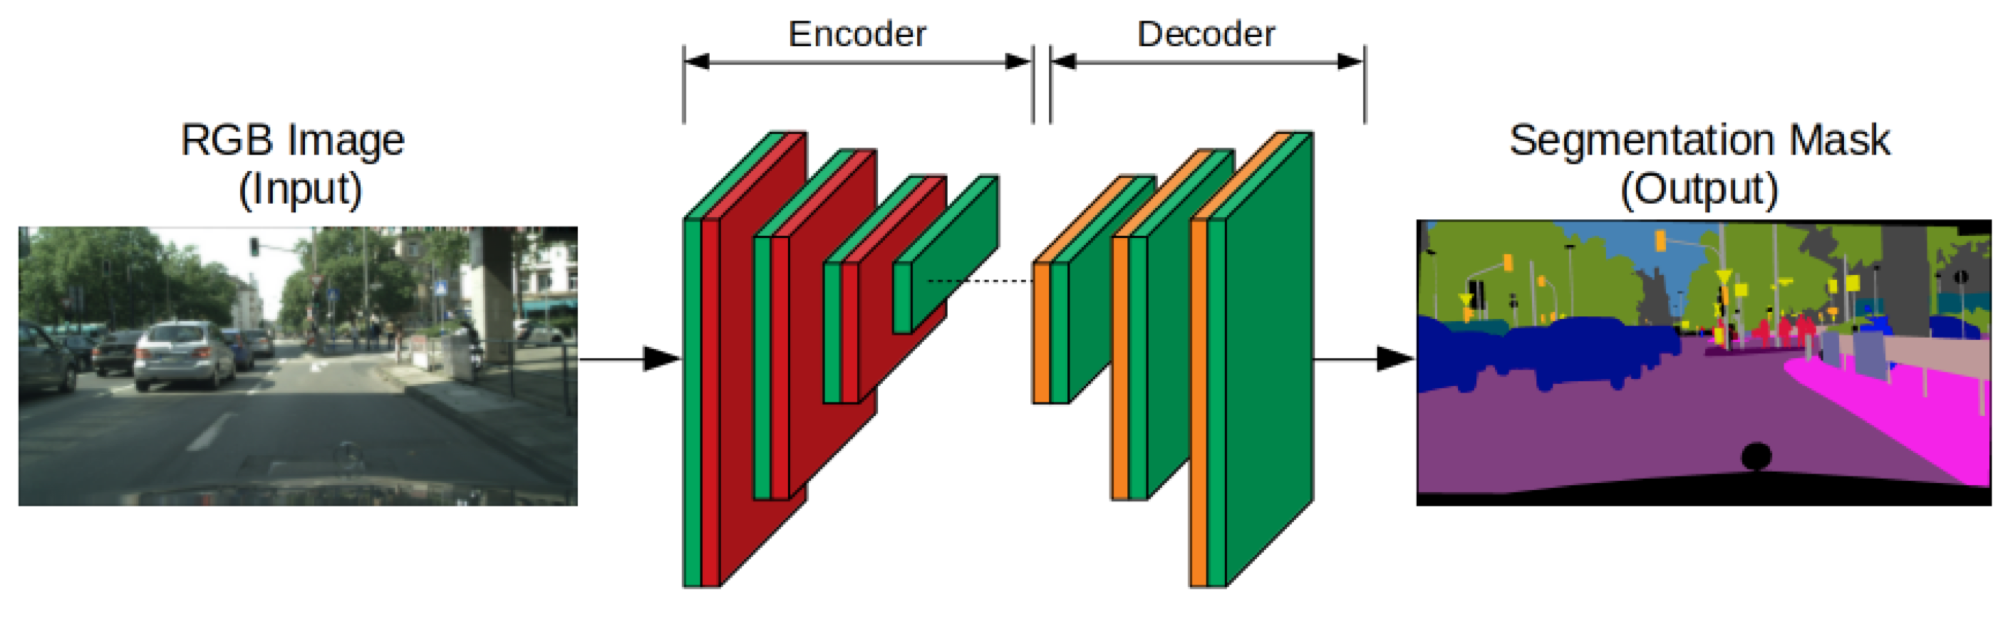

 FCN 은 Fully Convolutional Network 의 약자이고, 이것의 목적은 이미지를 세그멘테이션 하는 것이다. 이미지세그멘테이션이란, 위의 그림과같이 이미지의 각 픽셀이 어느 클래스에 속하는지 나타내는 것이다. FCN 은 CNN 기반의 모델이고, Encoder 파트와 Decoder 파트로 구성된다. 그리고, 기존의 CNN 기반 모델들은 출력층에 Fully Connected Layer 를 사용하는데, 그러면 이미지의 위치정보를 잃기때문에 FCN 에서는 Convolution Layer 로 대체한다. 


In [ ]:
# FCN 모델

def fcn(n=32):

    input_shape = Input(shape=(256, 256, 1))

    x = Conv2D(n, kernel_size=3, activation='relu', padding='same')(input_shape)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    x = Dropout(0.1)(x)

    x = Conv2D(n*2, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    x = Dropout(0.1)(x)

    x = Conv2D(n*4, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    x = Dropout(0.1)(x)

    x = Conv2D(n*8, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    x = Dropout(0.1)(x)

    x = Conv2D(n*16, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=2, padding='same')(x)
    x = Dropout(0.1)(x)

    x = Dense(n*16, activation='relu')(x)

    x = UpSampling2D(size=2)(x)
    x = Dropout(0.1)(x)
    x = Conv2D(n*8, kernel_size=3, activation='relu', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Dropout(0.1)(x)
    x = Conv2D(n*4, kernel_size=3, activation='relu', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Dropout(0.1)(x)
    x = Conv2D(n*2, kernel_size=3, activation='relu', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    x = Dropout(0.1)(x)
    x = Conv2D(n, kernel_size=3, activation='relu', padding='same')(x)

    x = UpSampling2D(size=2)(x)
    outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(x)

    model = Model(inputs=input_shape, outputs=outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 콜백 

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1, mode='auto'),
    ModelCheckpoint(filepath='model_lung.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
]

In [ ]:
# 모델을 만들고 학습시키기

model = fcn()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=16, callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 7s 65ms/step - loss: 1.6254 - accuracy: 0.7375 - val_loss: 0.6062 - val_accuracy: 0.7429

Epoch 00001: val_loss improved from inf to 0.60624, saving model to model_lung.h5
Epoch 2/100
15/15 [==============================] - 1s 35ms/step - loss: 0.5183 - accuracy: 0.7493 - val_loss: 0.4107 - val_accuracy: 0.7429

Epoch 00002: val_loss improved from 0.60624 to 0.41075, saving model to model_lung.h5
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 0.3658 - accuracy: 0.7551 - val_loss: 0.4141 - val_accuracy: 0.7429

Epoch 00003: val_loss did not improve from 0.41075
Epoch 4/100
15/15 [==============================] - 1s 35ms/step - loss: 0.3527 - accuracy: 0.7521 - val_loss: 0.3568 - val_accuracy: 0.7429

Epoch 00004: val_loss improved from 0.41075 to 0.35682, saving model to model_lung.h5
Epoch 5/100
15/15 [==============================] - 1s 36ms/step - loss: 0.2985 - accuracy: 0.7917 - val_loss: 0.3100 - va

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0     

In [ ]:
model.evaluate(x_val, y_val)

1/1 [==============================] - 0s 213ms/step - loss: 0.0989 - accuracy: 0.9540


[0.09887834638357162, 0.9540309309959412]

### FCN 결과

검증셋 loss = 0.0989

검증셋 accuracy = 0.9540


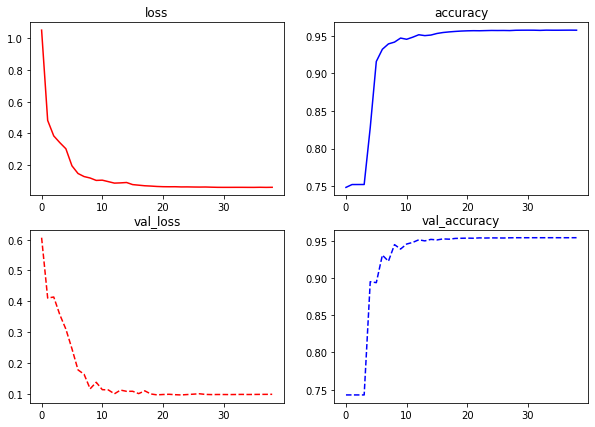

In [ ]:
# 모델이 잘 학습됐나 보기

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('accuracy')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_accuracy')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')

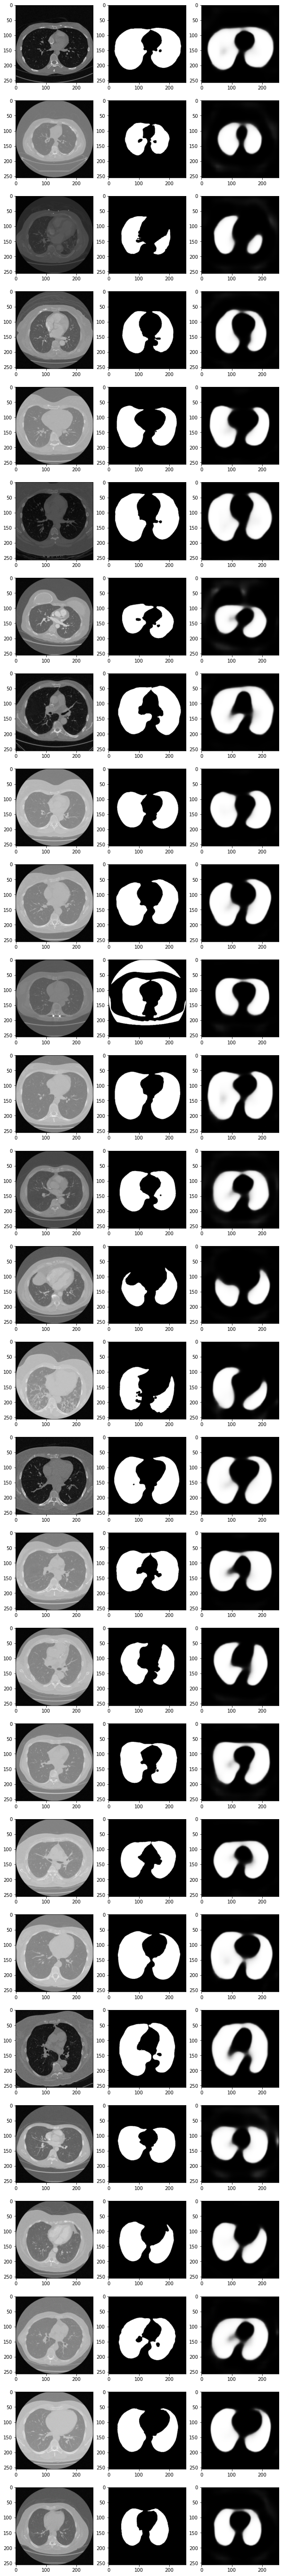

In [ ]:
# FCN 이 예측한 이미지 보기

preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

가장 왼쪽사진이 원래 CT 사진, 가운데가 실제 마스킹된 사진, 오른쪽이 모델이 예측한 이미지이다. 검증셋에대한 정확도가 95% 가 넘어서 기대했는데 많이 뿌옇게 나왔다. 

# UNET

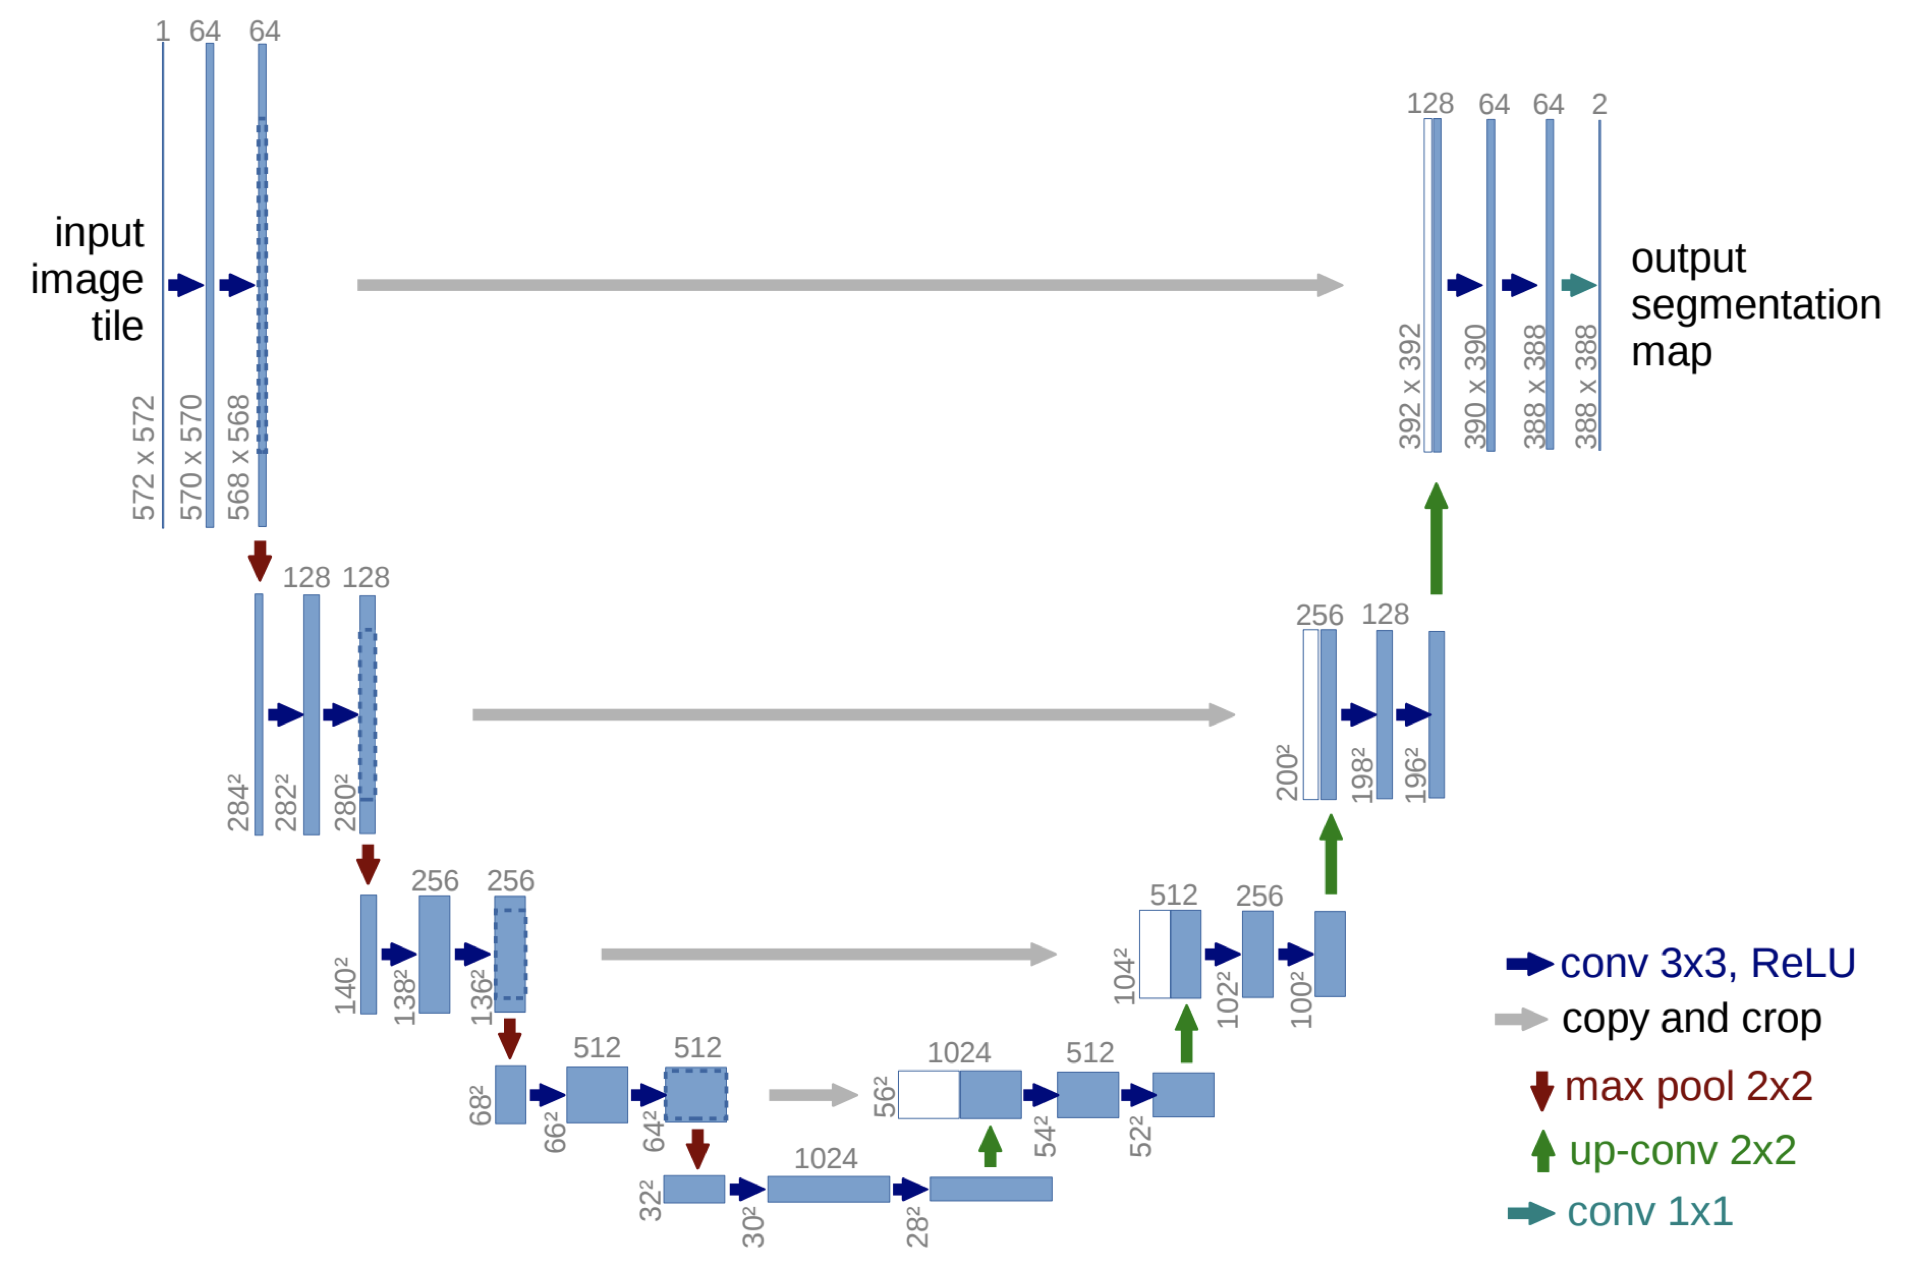

UNET 은 FCN 을 발전시킨 모델이고, FCN 과 마찬가지로 인코딩과 디코딩 파트로 구성되어있는데, 그것들을 UNET 에선 Contracting Path 와 Expanding Path 라고 부른다. Contracting Path 에서는 원본 이미지의 특징을 함축하는 과정이 이루어지고, Expanding Path 에서는 함축된 피쳐맵을 확장하는 과정이 이루어진다. 여기서 업샘플링하는 과정에서 Concatenate 를 사용하는 것이 특징인데, UNET 의 논문에 따르면 이것을 사용해서 대칭되는 Contracting Path 단계에서 얻어진 피쳐맵과 합치는 과정을 통해 예측 결과의 해상도를 높여준다고 한다. 

In [ ]:
# UNET 

def unet(n=32):
    input_shape = Input(shape=(256, 256, 1))
    bn    = BatchNormalization()(input_shape) 
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(bn)
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    
    pool4 = Dropout(0.1)(pool4)

    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convm)

    up6   = Conv2DTranspose(n*8, (2, 2), strides=(2, 2), padding='same')(convm)
    conv6 = concatenate([up6, conv4])
    conv6 = Dropout(0.1)(conv6)                   
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up7   = Conv2DTranspose(n*4, (2, 2), strides=(2, 2), padding='same')(conv6)
    conv7 = concatenate([up7, conv3])
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    up8   = Conv2DTranspose(n*2, (2, 2), strides=(2, 2), padding='same')(conv7)
    conv8 = concatenate([up8, conv2])
    conv8 = Dropout(0.1)(conv8)  
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up9   = Conv2DTranspose(n, (2, 2), strides=(2, 2), padding='same')(conv8)
    conv9 = concatenate([up9, conv1])
    conv9 = Dropout(0.1)(conv9) 
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=input_shape, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# 모델을 만들고 학습시키기

model2 = unet()

history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=16, callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 4s 135ms/step - loss: 0.4631 - accuracy: 0.7190 - val_loss: 2.1986 - val_accuracy: 0.7175

Epoch 00001: val_loss did not improve from 0.09682
Epoch 2/100
15/15 [==============================] - 1s 100ms/step - loss: 0.3140 - accuracy: 0.8306 - val_loss: 5.2716 - val_accuracy: 0.7429

Epoch 00002: val_loss did not improve from 0.09682
Epoch 3/100
15/15 [==============================] - 1s 100ms/step - loss: 0.3918 - accuracy: 0.8184 - val_loss: 0.9503 - val_accuracy: 0.7379

Epoch 00003: val_loss did not improve from 0.09682
Epoch 4/100
15/15 [==============================] - 1s 100ms/step - loss: 0.2660 - accuracy: 0.8648 - val_loss: 1.8356 - val_accuracy: 0.7437

Epoch 00004: val_loss did not improve from 0.09682
Epoch 5/100
15/15 [==============================] - 1s 100ms/step - loss: 0.2141 - accuracy: 0.8951 - val_loss: 1.6348 - val_accuracy: 0.7433

Epoch 00005: val_loss did not improve from 0.09682
Epoch 6/100
15/15 [======

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 1)  4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 32) 320         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_10[0][0]                  
____________________________________________________________________________________________

In [ ]:
model2.evaluate(x_val, y_val)

1/1 [==============================] - 0s 391ms/step - loss: 0.0548 - accuracy: 0.9594


[0.05484664440155029, 0.9594494700431824]

### UNET 결과

검증셋 loss = 0.0548

검증셋 accuracy = accuracy: 0.9594

FCN 결과(loss = 0.0989, accuracy = 0.9540)보다 좋아짐!

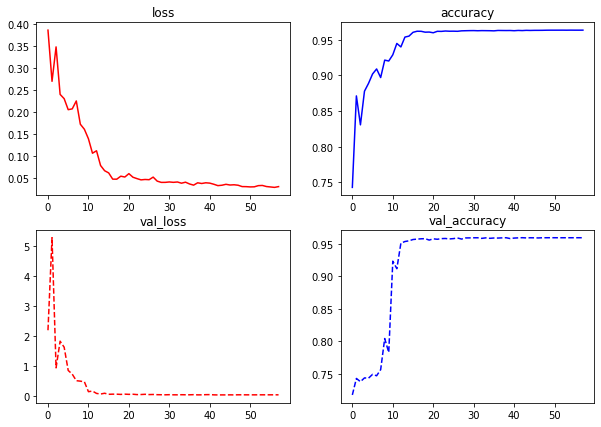

In [ ]:
# 학습이 잘 되었나 보기

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history2.history['loss'], 'r')
ax[0, 1].set_title('accuracy')
ax[0, 1].plot(history2.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history2.history['val_loss'], 'r--')
ax[1, 1].set_title('val_accuracy')
ax[1, 1].plot(history2.history['val_accuracy'], 'b--')

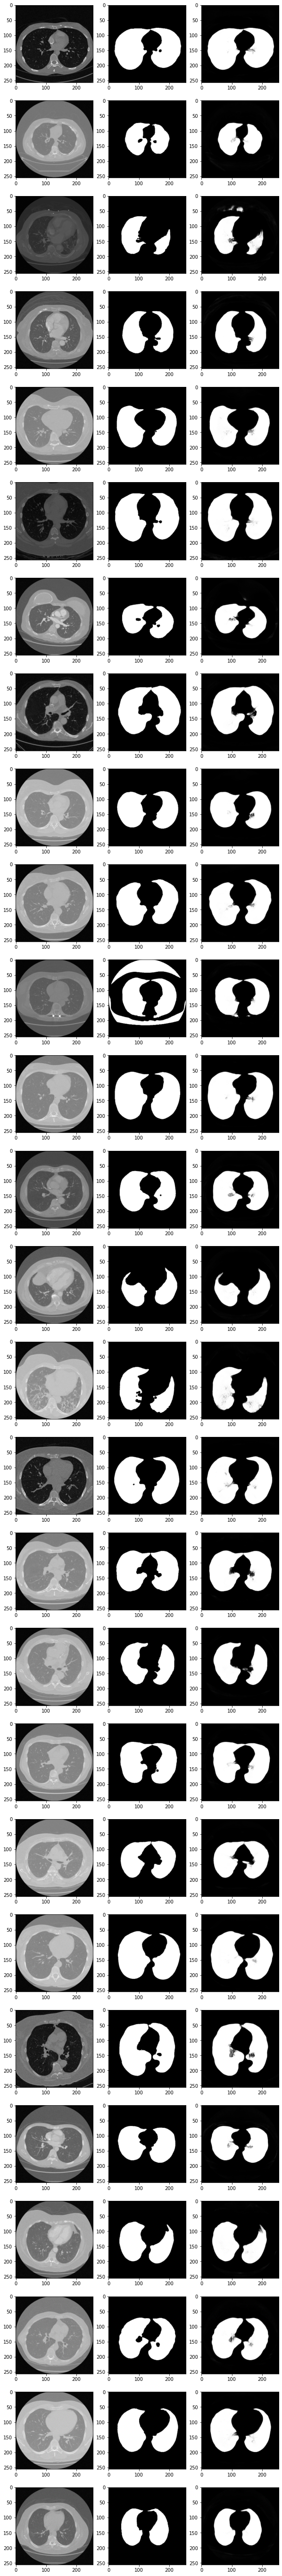

In [ ]:
# UNET 모델이 예측한 이미지 보기
preds2 = model2.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds2):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

가장 왼쪽사진이 원래 CT 사진, 가운데가 실제 마스킹된 사진, 오른쪽이 UNET 모델이 예측한 이미지이다. FCN 과 마찬가지로 검증셋에대한 정확도가 95% 인데 예측한 이미지의 해상도에 굉장히 차이가 있다. UNET 을 발표한 논문의 주장처럼, 업샘플링을 하는 과정에서 대칭되는 Contracting Path 단계에서 얻어진 피쳐맵과 합치는(Concatenate) 과정이 예측 결과의 해상도를 높여준 듯하다.

# Image Augmentation

의료이미지 특성상 많은 데이터를 확보하기가 쉽지않아서 모델학습과 평가에서 신뢰도가 떨어질 수 있어서 image augmentation 을 사용해 훈련세트의 다양성을 증가시켰다.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# mage Augmentation 을 하는 함수

def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=1)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=1)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

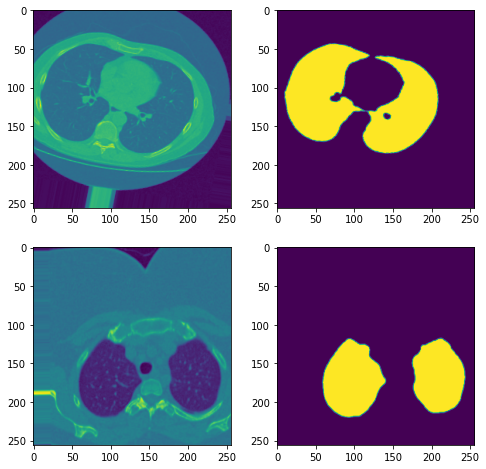

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 16))
fix, ax = plt.subplots(2,2, figsize=(8,8))
for i in range(2):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [ ]:
model4 = unet()

history4 = model4.fit_generator(my_generator(x_train, y_train, 32),
                           steps_per_epoch = 32,
                           validation_data = (x_val, y_val),
                           epochs=50, verbose=1,
                           callbacks = callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
32/32 [==============================] - 14s 382ms/step - loss: 0.4515 - accuracy: 0.7327 - val_loss: 2.0593 - val_accuracy: 0.5531

Epoch 00001: val_loss did not improve from 0.05082
Epoch 2/50
32/32 [==============================] - 12s 367ms/step - loss: 0.2959 - accuracy: 0.8431 - val_loss: 2.2059 - val_accuracy: 0.7420

Epoch 00002: val_loss did not improve from 0.05082
Epoch 3/50
32/32 [==============================] - 12s 362ms/step - loss: 0.2256 - accuracy: 0.8707 - val_loss: 1.0840 - val_accuracy: 0.7458

Epoch 00003: val_loss did not improve from 0.05082
Epoch 4/50
32/32 [==============================] - 12s 365ms/step - loss: 0.1501 - accuracy: 0.9103 - val_loss: 0.5062 - val_accuracy: 0.7946

Epoch 00004: val_loss did not improve from 0.05082
Epoch 5/50
32/32 [==============================] - 11s 359ms/step - loss: 0.1120 - accuracy: 0.9259 - val_loss: 0.2847 - val_accuracy: 0.8942

Epoch 00005: val_loss did not improve from 0.05082
Epoch 6/50
32/32 [=======

image augmentation 을 적용했지만 성능은 거의 비슷함! 

# CV 

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
# 5번 진행합니다.
kfold = KFold(n_splits=5, shuffle=True, random_state = 1)

In [ ]:
# 모델 만들기
model5 = unet()

# 5번 진행합니다.
for train_index, val_index in kfold.split(x_train):

    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    history5 = model5.fit_generator(my_generator(x_train_fold, y_train_fold, 32),
                           steps_per_epoch = 32,
                           validation_data = (x_val_fold, y_val_fold),
                           epochs=50, verbose=1,
                           callbacks = callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
32/32 [==============================] - 14s 409ms/step - loss: 0.8453 - accuracy: 0.6780 - val_loss: 3.0337 - val_accuracy: 0.7697

Epoch 00001: val_loss did not improve from 0.05082
Epoch 2/50
32/32 [==============================] - 13s 402ms/step - loss: 0.3176 - accuracy: 0.7817 - val_loss: 2.0188 - val_accuracy: 0.7692

Epoch 00002: val_loss did not improve from 0.05082
Epoch 3/50
32/32 [==============================] - 13s 397ms/step - loss: 0.2035 - accuracy: 0.8819 - val_loss: 1.1523 - val_accuracy: 0.7754

Epoch 00003: val_loss did not improve from 0.05082
Epoch 4/50
32/32 [==============================] - 13s 396ms/step - loss: 0.1934 - accuracy: 0.8843 - val_loss: 0.9803 - val_accuracy: 0.7800

Epoch 00004: val_loss did not improve from 0.05082
Epoch 5/50
32/32 [==============================] - 13s 397ms/step - loss: 0.1401 - accuracy: 0.9153 - val_loss: 0.4875 - val_accuracy: 0.8138

Epoch 00005: val_loss did not improve from 0.05082
Epoch 6/50
32/32 [=======

CV 를 통해 학습했을땐 최소 loss 가 0.050 -> 0.017 로 줄어들었다.

# 결과 

위에서 FCN 과 UNET 을 비교했을때 UNET 의 loss, accuracy 결과가 모두 좋았음. UNET 모델을 가지고 image augmentation 과 cross validation 을 적용했을때 정확도에선 큰 변화는 없었지만, loss 가 꽤 줄었다. 

**loss 변화** 

FCN => 0.0968

UNET => 0.0508

UNET + image augmentation => 0.0508

UNET + image augmentation + CV => 0.0176

.

**정확도 변화**

FCN => 0.9540

UNET => 0.9594

UNET + image augmentation => 0.9595

UNET + image augmentation + CV => 0.9595


# 모델 저장하기/불러오기

In [ ]:
from keras.models import load_model

# 모델 저장

model2.save('final_model')

INFO:tensorflow:Assets written to: final_model/assets


In [ ]:
# 저장된 모델 불러오기

model_final = load_model('final_model')

In [ ]:
# 가중치 로드
model_final.load_weights('model_lung.h5')

# 모델 평가
model_final.evaluate(x_val, y_val)

1/1 [==============================] - 0s 62ms/step - loss: 0.0698 - accuracy: 0.9593


[0.06982528418302536, 0.9592640995979309]

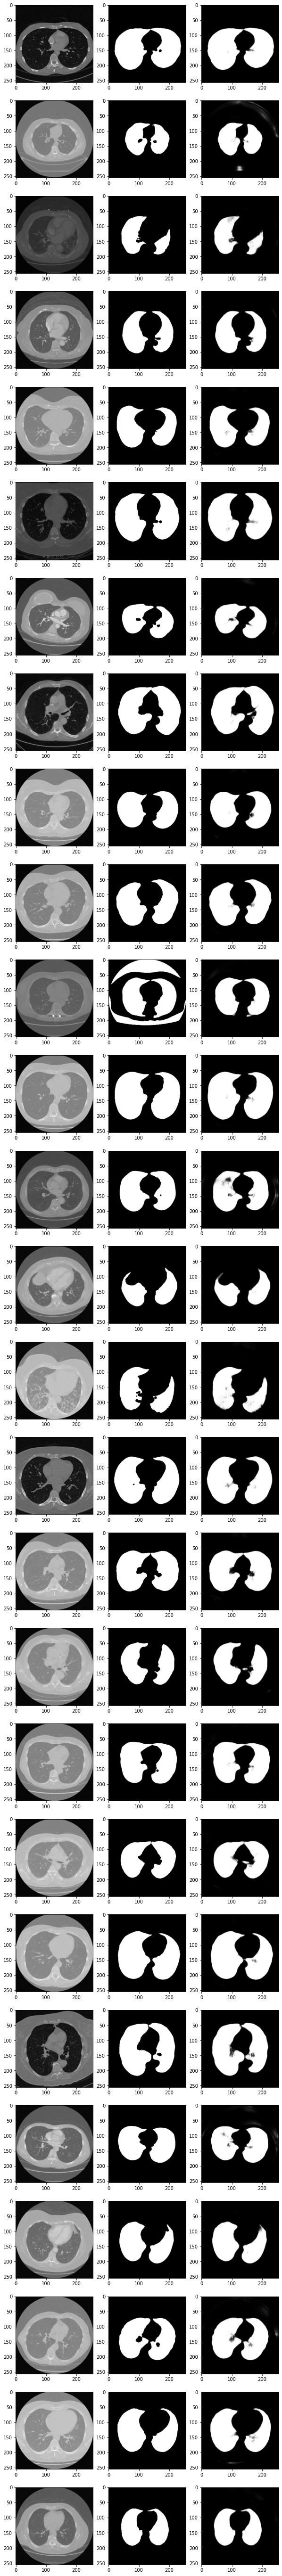

In [ ]:
# 불러온 데이터로 예측
preds_final = model_final.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds_final):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

# requirements.txt 파일 만들기

In [ ]:
pip freeze > requirements.txt

저장된 모델과 requirements.txt 를 사용해서 독립적인 환경에서 재구현을 하는 작업은 레포에있는 copy_project4.ipynb 파일에서 테스트했음!